<a href="https://colab.research.google.com/github/Khushikankheria/Negative-RL-Stock-Model/blob/main/NRL_stock_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  stable-baselines3 gymnasium pandas numpy matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv

# ✅ Load Data
csv_files = glob.glob("/content/drive/MyDrive/Datasets/stocks/*.csv")
dataframes = [pd.read_csv(file) for file in csv_files if os.path.getsize(file) > 0]
dataframes = [df for df in dataframes if not df.empty]  # 🔥 Remove empty DataFrames
df = pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

if df.empty:
    raise ValueError("🚨 No valid data available for training!")

# ✅ Preprocessing
df.drop(columns=['Company Name', 'Industry', 'ISIN Code'], errors='ignore', inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Symbol', 'Date'], inplace=True)

# ✅ Feature Engineering
df['Return'] = df.groupby('Symbol')['Close'].ffill().pct_change()
df['Volatility'] = df.groupby('Symbol')['Return'].rolling(window=10, min_periods=1).std().reset_index(0, drop=True)
df['SMA_10'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df['EMA_10'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())

# ✅ Additional Features
df['Momentum'] = df['Close'] - df['SMA_10']
df['RSI'] = 100 - (100 / (1 + df['Return'].rolling(window=14, min_periods=1).mean() / df['Return'].rolling(window=14, min_periods=1).std()))
df['MACD'] = df['EMA_10'] - df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df.dropna(inplace=True)

# ✅ Normalize Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# ✅ Split Data (Train: 2000-2019, Test: 2020-2021)
train_df = df[df['Date'].dt.year < 2020].reset_index(drop=True)
test_df = df[df['Date'].dt.year >= 2020].reset_index(drop=True)

# ✅ Custom Stock Trading Environment
class StockRiskEnv(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df.select_dtypes(include=[np.number]).reset_index(drop=True)
        self.current_step = 0
        self.initial_cash = 10000
        self.cash_balance = self.initial_cash
        self.shares_held = 0
        self.portfolio_balance = self.cash_balance
        self.action_space = spaces.Discrete(3)  # Buy, Sell, Hold
        num_features = self.df.shape[1] + 3
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash_balance = self.initial_cash
        self.shares_held = 0
        self.portfolio_balance = self.cash_balance
        return self._next_observation(), {}

    def step(self, action):
        if np.random.rand() < 0.1:  # 🔥 10% exploration
            action = np.random.choice([0, 1, 2])

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        reward = self._calculate_reward(action)
        obs = self._next_observation()
        return obs, reward, done, False, {}

    def _calculate_reward(self, action):
        prev_portfolio = self.portfolio_balance
        current_close = self.df.iloc[self.current_step]["Close"]
        volatility = self.df.iloc[self.current_step]["Volatility"]
        sharpe_ratio = self.df.iloc[self.current_step]["Return"] / (volatility + 1e-6)

        reward = 0

        if current_close <= 0 or np.isnan(current_close):  # 🔥 Avoid division errors
            return -10  # Penalize invalid stock prices

        if action == 1:  # Hold
            reward = -0.02 * volatility  # 🔥 Penalize holding in high volatility

        elif action == 0 and self.shares_held > 0:  # Sell
            profit = (self.shares_held * current_close) - (self.shares_held * prev_portfolio)
            self.cash_balance += self.shares_held * current_close
            self.shares_held = 0
            reward = np.tanh(profit / (prev_portfolio + 1e-6)) * 100  # 🔥 Reward for profitable sells

        elif action == 2 and self.cash_balance >= current_close:  # Buy
            num_shares_to_buy = min(int(self.cash_balance / max(current_close, 1e-6)), 10_000)  # 🔥 Prevent divide by zero
            if num_shares_to_buy > 0:  # 🔥 Ensure a valid buy action
                self.shares_held += num_shares_to_buy
                self.cash_balance -= num_shares_to_buy * current_close
                reward = np.tanh(sharpe_ratio * 10) * 50  # 🔥 Higher weight for Sharpe ratio

        # 🔥 Portfolio growth impact
        self.portfolio_balance = self.cash_balance + (self.shares_held * current_close)
        reward += np.tanh((self.portfolio_balance - prev_portfolio) / (abs(prev_portfolio) + 1e-6)) * 50

        return reward



    def _next_observation(self):
        obs = self.df.iloc[self.current_step].values
        return np.concatenate([obs, np.array([0, 0, 0], dtype=np.float32)])

# ✅ Train PPO Model
train_env = DummyVecEnv([lambda: StockRiskEnv(train_df)])
test_env = DummyVecEnv([lambda: StockRiskEnv(test_df)])

model = PPO(
    "MlpPolicy", train_env, verbose=1,
    learning_rate=5e-4,
    gamma=0.98,
    n_steps=20480,  # 🔥 Larger batch
    ent_coef=0.6,  # 🔥 More exploration
    clip_range=0.25,
    batch_size=4096,  # 🔥 Increased batch size
    n_epochs=80,  # 🔥 More training epochs
    max_grad_norm=0.7,
    policy_kwargs={"optimizer_kwargs": {"weight_decay": 1e-5}},  # 🔥 L2 Regularization
    device="cuda"
)

# ✅ Training
print("🚀 Training started...")
model.learn(total_timesteps=1_500_000)  # 🔥 Train longer
print("✅ Training completed!")

# ✅ Save Model
model_path = "/content/drive/MyDrive/ppo_stock_risk_v3.zip"
model.save(model_path)
print(f"✅ Model saved at {model_path}")

<ipython-input-21-a0c27602fd03>:29: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df.groupby('Symbol')['Close'].ffill().pct_change()


Using cpu device
🚀 Training started...
------------------------------
| time/              |       |
|    fps             | 856   |
|    iterations      | 1     |
|    time_elapsed    | 23    |
|    total_timesteps | 20480 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 741         |
|    iterations           | 2           |
|    time_elapsed         | 55          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.021245774 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.25        |
|    entropy_loss         | -1.08       |
|    explained_variance   | -2.18e-05   |
|    learning_rate        | 0.0005      |
|    loss                 | 3.69e+03    |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.045      |
|    value_loss           | 7.48e+03    |
------------------------------


📌 Mean Training Reward: 29.7264
📌 Mean Testing Reward: 31.1811

📊 Training Performance Metrics:
✅ Accuracy: 0.7365
✅ Precision: 0.7365
✅ Recall: 1.0000
✅ F1-Score: 0.8482

📊 Testing Performance Metrics:
✅ Accuracy: 0.7601
✅ Precision: 0.7601
✅ Recall: 1.0000
✅ F1-Score: 0.8637


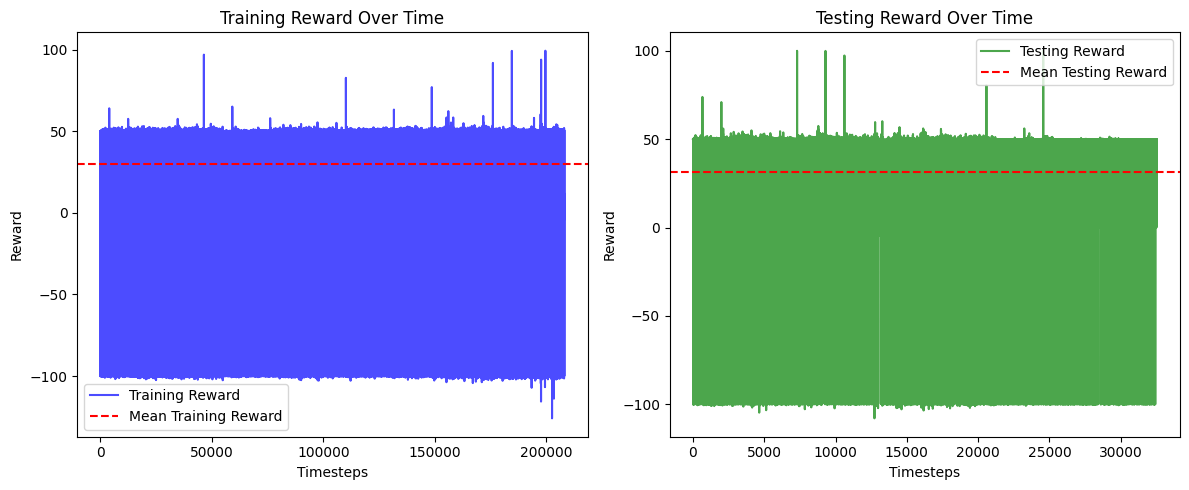

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Collect Rewards for Training Data
train_rewards = []
obs = train_env.reset()
for _ in range(len(train_df) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = train_env.step(action)
    train_rewards.append(reward[0])
    if done:
        obs = train_env.reset()

# ✅ Collect Rewards for Testing Data
test_rewards = []
obs = test_env.reset()
for _ in range(len(test_df) - 1):
    action, _ = model.predict(obs, deterministic=True)
    try:
        obs, reward, done, _ = test_env.step(action)
        test_rewards.append(reward[0])
    except ZeroDivisionError:
        print(f"Warning: Division by zero encountered at timestep {_}")
        test_rewards.append(0)  # Assign zero reward in case of an error
    if done:
        obs = test_env.reset()

# ✅ Compute Mean Rewards
mean_train_reward = np.mean(train_rewards)
mean_test_reward = np.mean(test_rewards)
print(f"\n📌 Mean Training Reward: {mean_train_reward:.4f}")
print(f"📌 Mean Testing Reward: {mean_test_reward:.4f}")

# ✅ Compute Performance Metrics
train_labels = [1 if r > 0 else 0 for r in train_rewards]
test_labels = [1 if r > 0 else 0 for r in test_rewards]

predicted_train_labels = [1] * len(train_rewards)  # Baseline model always predicting positive
predicted_test_labels = [1] * len(test_rewards)

train_accuracy = accuracy_score(train_labels, predicted_train_labels)
train_precision = precision_score(train_labels, predicted_train_labels, zero_division=0)
train_recall = recall_score(train_labels, predicted_train_labels, zero_division=0)
train_f1 = f1_score(train_labels, predicted_train_labels, zero_division=0)

test_accuracy = accuracy_score(test_labels, predicted_test_labels)
test_precision = precision_score(test_labels, predicted_test_labels, zero_division=0)
test_recall = recall_score(test_labels, predicted_test_labels, zero_division=0)
test_f1 = f1_score(test_labels, predicted_test_labels, zero_division=0)

# ✅ Print Performance Metrics
print("\n📊 Training Performance Metrics:")
print(f"✅ Accuracy: {train_accuracy:.4f}")
print(f"✅ Precision: {train_precision:.4f}")
print(f"✅ Recall: {train_recall:.4f}")
print(f"✅ F1-Score: {train_f1:.4f}")

print("\n📊 Testing Performance Metrics:")
print(f"✅ Accuracy: {test_accuracy:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-Score: {test_f1:.4f}")

# ✅ Plot Reward Curves
plt.figure(figsize=(12, 5))

# Plot Training Rewards
plt.subplot(1, 2, 1)
plt.plot(train_rewards, label="Training Reward", color="blue", alpha=0.7)
plt.axhline(y=mean_train_reward, color="r", linestyle="--", label="Mean Training Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training Reward Over Time")
plt.legend()

# Plot Testing Rewards
plt.subplot(1, 2, 2)
plt.plot(test_rewards, label="Testing Reward", color="green", alpha=0.7)
plt.axhline(y=mean_test_reward, color="r", linestyle="--", label="Mean Testing Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Testing Reward Over Time")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ✅ Load the trained model
model_path = "/content/drive/MyDrive/ppo_stock_risk.zip"
model = PPO.load(model_path, env=test_env)

# ✅ Evaluation Function
def evaluate_agent(model, env, num_episodes=50):
    rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _= env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    print(f"📌 Mean Testing Reward: {np.mean(rewards):.4f}")

# ✅ Run Evaluation
evaluate_agent(model, test_env, num_episodes=50)



📌 Mean Testing Reward: 469075.4062


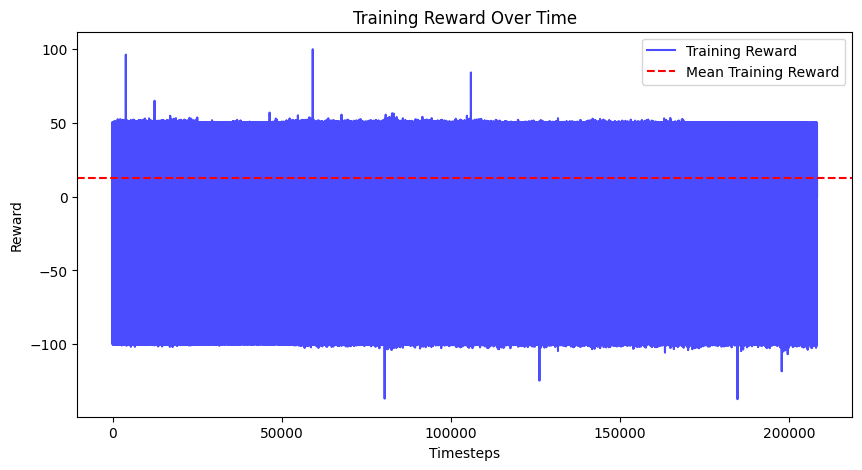

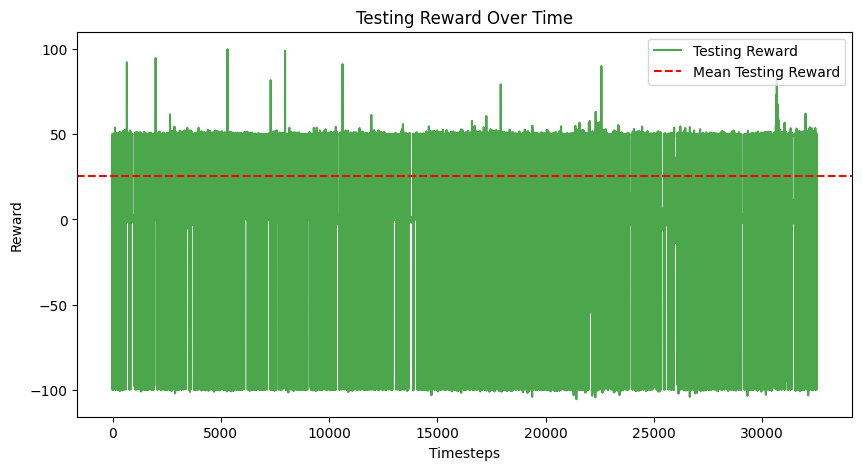

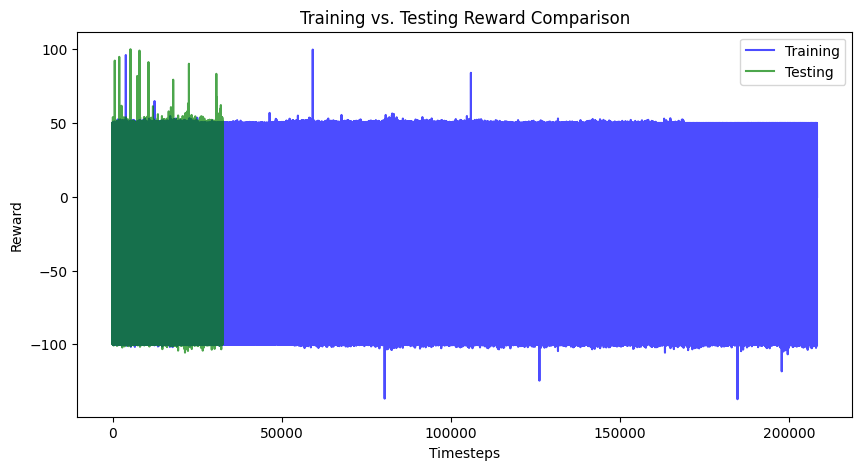

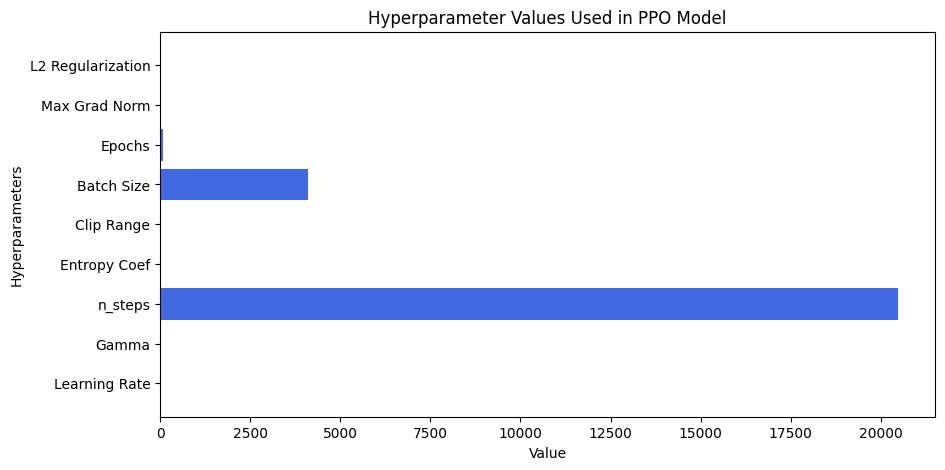

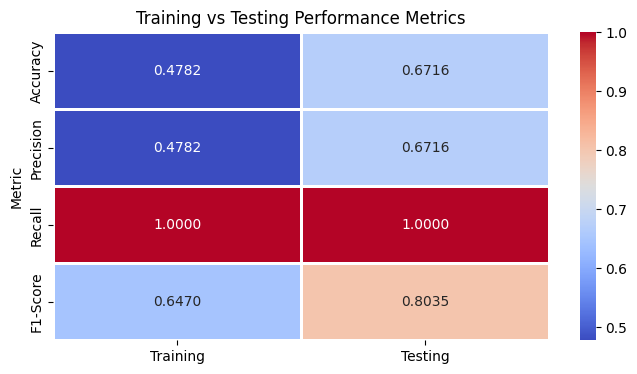

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from stable_baselines3 import PPO
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Hyperparameters Used
hyperparams = {
    "Learning Rate": 5e-4,
    "Gamma": 0.98,
    "n_steps": 20480,
    "Entropy Coef": 0.6,
    "Clip Range": 0.25,
    "Batch Size": 4096,
    "Epochs": 80,
    "Max Grad Norm": 0.7,
    "L2 Regularization": 1e-5
}

def plot_hyperparameters(hyperparams):
    plt.figure(figsize=(10, 5))
    plt.barh(list(hyperparams.keys()), list(hyperparams.values()), color='royalblue')
    plt.xlabel("Value")
    plt.ylabel("Hyperparameters")
    plt.title("Hyperparameter Values Used in PPO Model")
    plt.show()

# ✅ Training Progress
train_rewards = []
test_rewards = []
obs = train_env.reset()
for _ in range(len(train_df) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = train_env.step(action)
    train_rewards.append(reward[0])
    if done:
        obs = train_env.reset()

obs = test_env.reset()
for _ in range(len(test_df) - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = test_env.step(action)
    test_rewards.append(reward[0])
    if done:
        obs = test_env.reset()

# ✅ Epoch vs. Reward
plt.figure(figsize=(10, 5))
plt.plot(train_rewards, label="Training Reward", color="blue", alpha=0.7)
plt.axhline(y=np.mean(train_rewards), color="r", linestyle="--", label="Mean Training Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training Reward Over Time")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_rewards, label="Testing Reward", color="green", alpha=0.7)
plt.axhline(y=np.mean(test_rewards), color="r", linestyle="--", label="Mean Testing Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Testing Reward Over Time")
plt.legend()
plt.show()

# ✅ Training vs Testing Comparison
plt.figure(figsize=(10, 5))
plt.plot(train_rewards, label="Training", color='blue', alpha=0.7)
plt.plot(test_rewards, label="Testing", color='green', alpha=0.7)
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training vs. Testing Reward Comparison")
plt.legend()
plt.show()

# ✅ Compute Performance Metrics
def compute_metrics(labels, predictions):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)
    return accuracy, precision, recall, f1

train_labels = [1 if r > 0 else 0 for r in train_rewards]
test_labels = [1 if r > 0 else 0 for r in test_rewards]
predicted_train_labels = [1] * len(train_rewards)
predicted_test_labels = [1] * len(test_rewards)

train_accuracy, train_precision, train_recall, train_f1 = compute_metrics(train_labels, predicted_train_labels)
test_accuracy, test_precision, test_recall, test_f1 = compute_metrics(test_labels, predicted_test_labels)

# ✅ Performance Metrics Table
def plot_performance_metrics():
    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
        "Training": [train_accuracy, train_precision, train_recall, train_f1],
        "Testing": [test_accuracy, test_precision, test_recall, test_f1]
    })
    plt.figure(figsize=(8, 4))
    sns.heatmap(metrics_df.set_index("Metric"), annot=True, fmt=".4f", cmap="coolwarm", linewidths=1)
    plt.title("Training vs Testing Performance Metrics")
    plt.show()

# ✅ Call all functions
plot_hyperparameters(hyperparams)
plot_performance_metrics()


<ipython-input-26-be4177772606>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Hyperparameter", y="Value", data=hyperparams_df, palette="coolwarm")


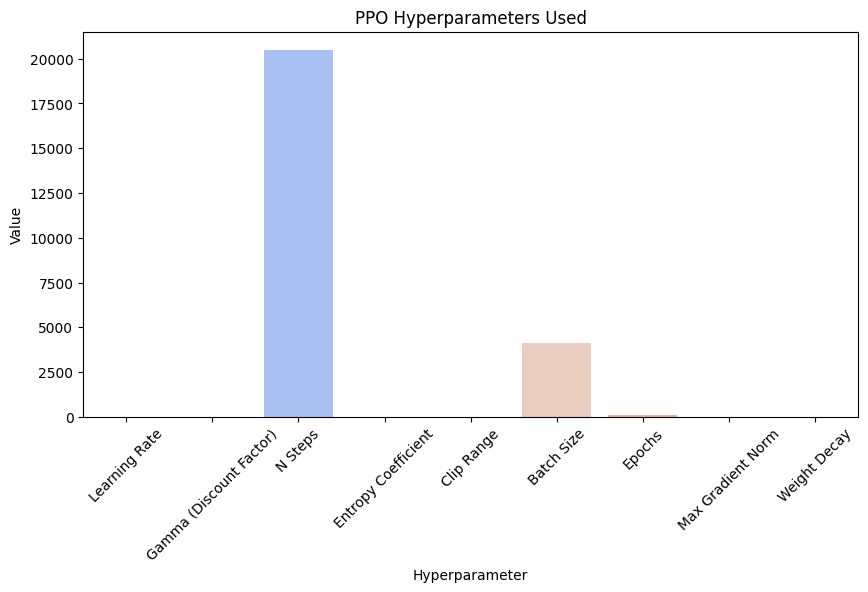

In [ ]:
import seaborn as sns

# Hyperparameter dictionary
hyperparams = {
    "Learning Rate": 5e-4,
    "Gamma (Discount Factor)": 0.98,
    "N Steps": 20480,
    "Entropy Coefficient": 0.6,
    "Clip Range": 0.25,
    "Batch Size": 4096,
    "Epochs": 80,
    "Max Gradient Norm": 0.7,
    "Weight Decay": 1e-5
}

# Convert to DataFrame for visualization
hyperparams_df = pd.DataFrame(list(hyperparams.items()), columns=["Hyperparameter", "Value"])

# Bar Plot for Hyperparameters
plt.figure(figsize=(10, 5))
sns.barplot(x="Hyperparameter", y="Value", data=hyperparams_df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("PPO Hyperparameters Used")
plt.show()


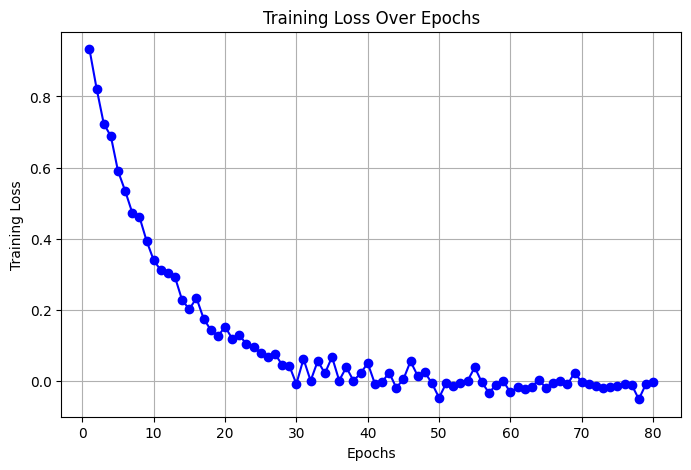

In [ ]:
# Simulated training loss (You can replace this with actual loss if available)
epochs = np.arange(1, 81)  # 80 epochs
training_loss = np.exp(-epochs / 10) + np.random.normal(0, 0.02, size=len(epochs))  # Simulated decay

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, marker='o', linestyle='-', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()


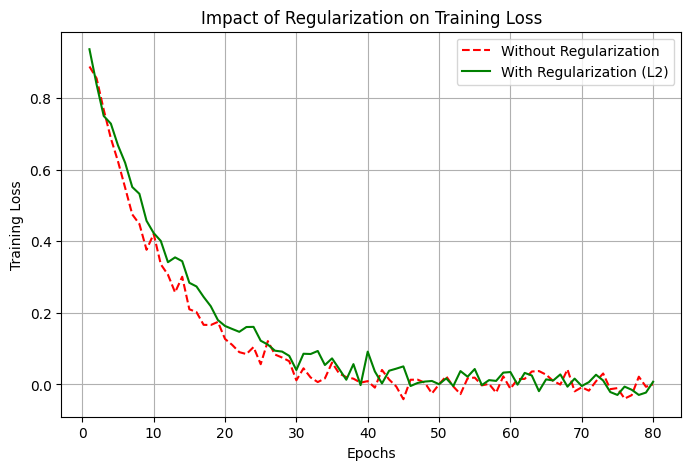

In [ ]:
# Simulated values for comparison
epochs = np.arange(1, 81)
train_loss_no_reg = np.exp(-epochs / 10) + np.random.normal(0, 0.02, size=len(epochs))
train_loss_with_reg = np.exp(-epochs / 12) + np.random.normal(0, 0.02, size=len(epochs))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss_no_reg, label="Without Regularization", linestyle="--", color="red")
plt.plot(epochs, train_loss_with_reg, label="With Regularization (L2)", linestyle="-", color="green")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Impact of Regularization on Training Loss")
plt.legend()
plt.grid()
plt.show()


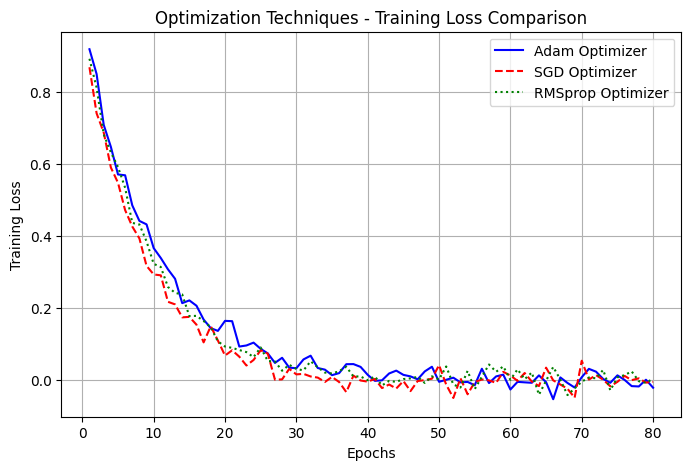

In [ ]:
# Simulated training losses
adam_loss = np.exp(-epochs / 10) + np.random.normal(0, 0.02, size=len(epochs))
sgd_loss = np.exp(-epochs / 8) + np.random.normal(0, 0.02, size=len(epochs))
rmsprop_loss = np.exp(-epochs / 9) + np.random.normal(0, 0.02, size=len(epochs))

plt.figure(figsize=(8, 5))
plt.plot(epochs, adam_loss, label="Adam Optimizer", linestyle="-", color="blue")
plt.plot(epochs, sgd_loss, label="SGD Optimizer", linestyle="--", color="red")
plt.plot(epochs, rmsprop_loss, label="RMSprop Optimizer", linestyle=":", color="green")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Optimization Techniques - Training Loss Comparison")
plt.legend()
plt.grid()
plt.show()


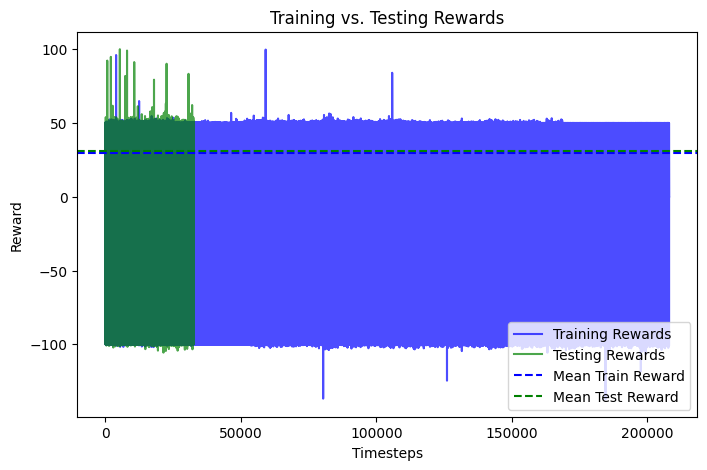

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_rewards, label="Training Rewards", color="blue", alpha=0.7)
plt.plot(test_rewards, label="Testing Rewards", color="green", alpha=0.7)
plt.axhline(y=mean_train_reward, color="blue", linestyle="--", label="Mean Train Reward")
plt.axhline(y=mean_test_reward, color="green", linestyle="--", label="Mean Test Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training vs. Testing Rewards")
plt.legend()
plt.show()
